# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 4 minutes

This notebooks demonstrates the usage of a variant on the [Network Perturbation Amplitude](http://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-6-54) algorithm to analyze an BEL knowledge assembly in the context of a differential gene expression experiment. 

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
import logging
import pybel
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
import pybel_tools as pbt
from pybel_tools.visualization import to_jupyter
import pybel_tools.analysis.npa as npa

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
pybel.__version__

'0.4.1'

In [3]:
pbt.__version__

'0.1.3-dev'

In [4]:
graph_vis_width = 1000
graph_vis_height = 650

In [5]:
bms_base = os.environ['BMS_BASE']
owncloud_base = os.environ['OWNCLOUD_BASE']

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [6]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [7]:
graph = pybel.from_pickle(pickle_path)

All orthologies are discared before analysis.

In [8]:
pbt.mutation.remove_nodes_by_namespace(graph, GENE, 'MGI')
pbt.mutation.remove_nodes_by_namespace(graph, RNA, 'MGI')
pbt.mutation.remove_nodes_by_namespace(graph, PROTEIN, 'MGI')

pbt.mutation.remove_nodes_by_namespace(graph, GENE, 'RGD')
pbt.mutation.remove_nodes_by_namespace(graph, RNA, 'RGD')
pbt.mutation.remove_nodes_by_namespace(graph, PROTEIN, 'RGD')

To merge the differential gene expression annotations, the entire graph must be collapsed to genes using `pbt.mutation.opening_by_central_dogma_to_genes`

In [9]:
pbt.mutation.opening_by_central_dogma_to_genes(graph)
pbt.mutation.collapse_variants_to_genes(graph)

In [10]:
pbt.summary.print_summary(graph)

Name: 
Number of nodes: 9269
Number of edges: 58301
Network density: 0.0006786675695545498
Number weakly connected components: 55
Average in-degree: 6.289891034631568
Average out-degree: 6.289891034631568


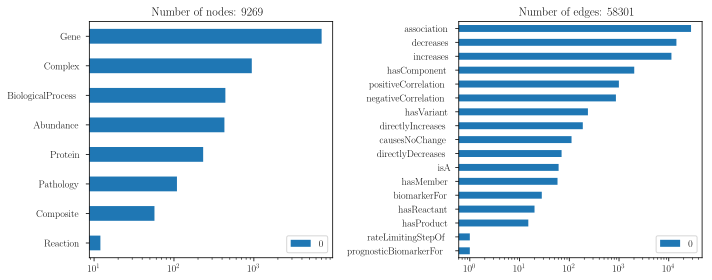

In [11]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

## Differential Gene Expression

Differential gene expression data can be obtained from many sources, including ADNI and other large clinical studies. This analysis is concerned with the log-fold-changes on each gene, and not necessarily the p-value. This is better as a data-driven process becuase it does not require a model or multiple hypothesis testing on raw data.

In [12]:
data_path = os.path.join(owncloud_base, 'SevAD.csv')
target_columns = ['Gene.symbol', 'logFC']

In [13]:
df = pd.read_csv(data_path)
df = df.loc[df['Gene.symbol'].notnull(), target_columns]
df.head()

Gene.symbol     logFC
0      ZNF616 -4.244691
1     DEFB125  3.974393
3      SNAP23  3.337636
4      PHLDB2  3.192559
5   LOC389895 -4.296850

A histogram of the log-fold-changes shows that the data are normally distributed, as expected for differential gene expression data.

In [14]:
# max_fc = {}
# for row, symbol, fc in df.itertuples():
#    if symbol not in max_fc or abs(max_fc[symbol]) < abs(fc):
#        max_fc[symbol] = fc
        
data = {k: v for _, k, v in df.itertuples()}

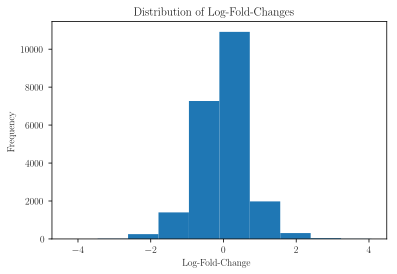

In [15]:
plt.title('Distribution of Log-Fold-Changes')
plt.xlabel('Log-Fold-Change')
plt.ylabel('Frequency')
plt.hist(list(data.values()))
plt.show()

## Overlap Summary

The number of shared elements in the knowledge assembly and differential gene data set are counted.

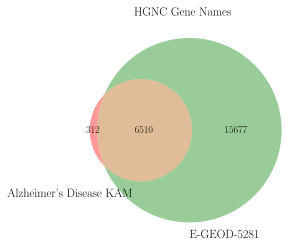

In [16]:
hgnc_names = pbt.summary.get_names(graph, 'HGNC')
df_names = set(df['Gene.symbol'])
overlapping_hgnc_names = hgnc_names & df_names

plt.title('HGNC Gene Names')
venn2([hgnc_names, df_names], set_labels=["Alzheimer's Disease KAM", 'E-GEOD-5281'])
plt.show()

# Analysis

## Data Integration

Finally, the differential gene expression data are ovelayed on the BEL graph with [pbt.integration.overlay_type_data](http://pybel-tools.readthedocs.io/en/latest/integration.html#pybel_tools.integration.overlay_type_data)

In [17]:
label = 'weight'

In [18]:
pbt.integration.overlay_type_data(graph, data, label, GENE, 'HGNC', overwrite=False, impute=0)

## Subgraph Generation

A subgraph is induced around an example biological process, Inflammatory Response, by selecting all of the source nodes of upstream causal edges, where this process is the target node. These networks are then enriched by expandind around all of those nodes' upstream edges as well.

In [19]:
inflamation_node = BIOPROCESS, 'GOBP', 'inflammatory response'

### Iteration 1/2

All of the nodes that have upstream causal relations to Inflammatory Response are added.

In [20]:
subgraph = pbt.mutation.get_upstream_causal_subgraph(graph, inflamation_node)

pbt.summary.print_summary(subgraph)
to_jupyter(subgraph)

Name: 
Number of nodes: 32
Number of edges: 53
Network density: 0.05342741935483871
Number weakly connected components: 1
Average in-degree: 1.65625
Average out-degree: 1.65625


<IPython.core.display.Javascript object>

### Iteration 2/2

All of the nodes upstream of the nodes within the subgraph are added as well.

In [21]:
pbt.mutation.expand_upstream_causal_subgraph(graph, subgraph)
pbt.summary.print_summary(subgraph)

Name: 
Number of nodes: 278
Number of edges: 1188
Network density: 0.01542736929589902
Number weakly connected components: 1
Average in-degree: 4.273381294964029
Average out-degree: 4.273381294964029


### Post-Processing

Inconsistient edges are thrown away, literature bias is removed, and nodes on the periphery of the subgraph that are not annotated with experimental data are also removed, since they cannot contribute to the propogation of scores.

In [22]:
pbt.mutation.remove_inconsistent_edges(graph)

In [23]:
pbt.mutation.collapse_consistent_edges(graph)

In [24]:
pbt.generation.remove_unweighted_leaves(subgraph, label)

In [25]:
pbt.generation.remove_unweighted_sources(subgraph, label)

In [26]:
pbt.summary.print_summary(subgraph)
to_jupyter(subgraph)

Name: 
Number of nodes: 129
Number of edges: 740
Network density: 0.04481589147286822
Number weakly connected components: 1
Average in-degree: 5.736434108527132
Average out-degree: 5.736434108527132


<IPython.core.display.Javascript object>

This entire procedure can be run automatically with [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism)

## Running

In [27]:
runner = npa.NpaRunner(subgraph, inflamation_node, label)

While the algorithm can be immediately run with [pbt.analysis.npa.NpaRunner.run](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.NpaRunner.run), the process is outlined to show the evolution of the graph throughouts its steps. For animation purposes, the functin [pbt.analysis.npa.NpaRunner.run_with_graph_transformation](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.NpaRunner.run_with_graph_transformation) yields a new `BELGraph` at each step through the process as well.

In [28]:
runner.score_leaves()

{('Abundance', 'BRCO', 'Astrocyte'),
 ('Abundance', 'CHEBI', 'leukotriene'),
 ('Abundance', 'MESHCS', 'Neurofibrillary Tangles'),
 ('Gene', 'HGNC', 'CD14'),
 ('Gene', 'HGNC', 'CHI3L1'),
 ('Gene', 'HGNC', 'IL23A'),
 ('Gene', 'HGNC', 'IRAK1'),
 ('Gene', 'HGNC', 'IRAK2'),
 ('Gene', 'HGNC', 'PTX3'),
 ('Gene', 'HGNC', 'TLR2')}

In [29]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [30]:
runner.score_leaves()

{('Gene', 'HGNC', 'IL12B')}

In [31]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [32]:
runner.score_leaves()

[]

In [33]:
runner.remove_random_edge()

to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [34]:
runner.score_leaves()

{('Gene', 'HGNC', 'SCARB1')}

In [35]:
runner.score_leaves()

[]

In [36]:
runner.remove_random_edge()
leaves = runner.score_leaves()
len(leaves)

1

In [37]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [38]:
runner.run()

In [39]:
runner.get_final_score()

74.162180860000021

## Robustness Analysis

The algorithm is random, so it can be run multiple times to assess the robustness of the final scores using [pbt.analysis.npa.multirun](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.multirun)

In [40]:
%%time
runners = list(npa.multirun(subgraph, inflamation_node, label, default_score=0, runs=500))

CPU times: user 22.1 s, sys: 281 ms, total: 22.4 s
Wall time: 22.4 s


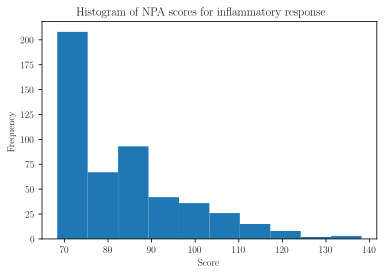

In [41]:
plt.title('Histogram of NPA scores for {}'.format(calculate_canonical_name(subgraph, inflamation_node)))
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.hist([runner.get_final_score() for runner in runners])
plt.show()

## Full Workflow

This workflow can all be run with [pbt.analysis.npa.workflow_all_average](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.workflow_all_average) but is outlined here for a deeper understanding.

### Generate Candidate Mechanisms

Candidate mechanism are generated with the aforementioned function [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism) to assess the upstream causal subgraphs of all biological processes.

In [42]:
all_bioprocesses = pbt.selection.get_nodes_by_function(graph, BIOPROCESS)

In [43]:
%%time
candidate_mechanisms = {node: pbt.generation.generate_mechanism(graph, node, label) for node in all_bioprocesses}

CPU times: user 1.85 s, sys: 18.8 ms, total: 1.87 s
Wall time: 1.87 s


In [44]:
%%time
scores = {}

for i, (node, subgraph) in enumerate(candidate_mechanisms.items()):
    average_score = npa.multirun_average(subgraph, node, label, runs=40)
    scores[node] = average_score

CPU times: user 21.4 s, sys: 252 ms, total: 21.6 s
Wall time: 21.8 s


In [45]:
len(candidate_mechanisms), sum(1 for score in scores.values() if score)

(440, 239)

In [46]:
scores_cute_names = {calculate_canonical_name(graph, n): s for n, s in scores.items()}

In [47]:
scores_df = pd.DataFrame.from_dict(scores_cute_names, orient='index')

The distribution of average NPA scores is shown to be mostly normal.

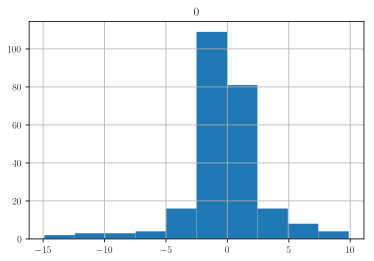

In [48]:
scores_df.hist()
plt.show()

In [49]:
scores_df[scores_df[0].notnull()].sort_values(0)

0
positive regulation of neuron apoptotic process    -14.896657
glial cell differentiation                         -13.059167
production of molecular mediator involved in in... -10.993091
cell death                                         -10.718924
chronic inflammatory response                      -10.368632
neuron apoptotic process                            -9.245212
beta-amyloid formation                              -7.770215
cell-matrix adhesion                                -7.657543
negative regulation of neuron projection regene...  -6.735642
vasoconstriction                                    -5.107942
reactive oxygen species metabolic process           -5.033316
negative regulation of calcium-mediated signaling   -4.989171
Lipid Peroxidation                                  -4.961603
response to oxidative stress                        -4.576016
DNA biosynthetic process                            -3.907494
phagocytosis                                        -3.826924
apoptotic process                                   -3.613041
gliogenesis                                         -3.318600
regulation of glucose metabolic process             -3.199888
beta-amyloid clearance                              -2.650228
cell-cell signaling                                 -2.552514
synapse assembly                                    -2.552514
cell adhesion                                       -2.552514
regulation of growth                                -2.552514
growth                                              -2.552514
synaptic transmission, glutamatergic                -2.552514
RNA metabolic process                               -2.552514
cell migration                                      -2.552514
response to endoplasmic reticulum stress            -2.486175
response to reactive oxygen species                 -2.480802
...                                                       ...
cAMP-mediated signaling                              2.408039
leukocyte mediated immunity                          2.408039
mitochondrial transport                              2.480802
regulation of synaptic transmission, cholinergic     2.480802
axon transport of mitochondrion                      2.480802
sodium ion homeostasis                               2.480802
nitric oxide-cGMP-mediated signaling pathway         2.480802
regulation of cellular response to oxidative st...   2.552514
regulation of neuronal synaptic plasticity           2.625366
reelin-mediated signaling pathway                    3.116388
Insulin Resistance                                   3.314902
learning                                             3.363660
regulation of synaptic plasticity                    3.944863
negative regulation of microtubule depolymeriza...   3.968856
generation of neurons                                3.968856
blood circulation                                    4.051542
calcium ion import                                   4.303770
positive regulation of Notch signaling pathway       4.398431
calcium ion homeostasis                              4.995532
negative regulation of neuron apoptotic process      5.010068
protein import into mitochondrial matrix             5.033316
electron transport chain                             5.033316
mitochondrial calcium ion homeostasis                5.033316
regulation of catalytic activity                     5.056096
energy reserve metabolic process                     6.602340
glucose metabolic process                            6.602340
mitochondria-nucleus signaling pathway               7.776194
cognition                                            8.760978
mitochondrion organization                           9.773005
memory                                               9.880314

[246 rows x 1 columns]

# Conclusions

## Problems

This algorithm overcomes deterministic problems with cyclic graphs by randomly removing edges. It can be run multiple times to assess the stability of the score with `pbt.analysis.npa.average_npa_run`. The effect of the default score can also be checked with a grid search.

## Looking Forward

While this new algorithm is generally applicable and overcomes the original algorithm, it must throw away information to do so. Further algorithmic development, such as heat diffusion approaches could allow for a more thorough investigation of the propogation of effects of the differential gene expression.

This algorithm can be run over the mechanisms generated for each biological process. Further investigation into the upstream mechanism generation can yield bias-free candidate mechanisms. They can also be matched to canonical mechanisms in NeuroMMSigDB to identify concordance between the biological dogma and all possible mechanisms, then to identify previously unknown cross-talk between mechanisms.